## Potential Talents - Part 2

----

This notebook trains a **mini Word2Vec** model using **Skip-gram with Negative Sampling (SGNS)** on a small corpus, then provides utilities to **explore the vector space**: cosine similarity, nearest neighbors, and classical analogies.


#### Objectives:

- Prepare a small text corpus
- Build a vocabulary with `min_count` and subsampling.
- Train SGNS in PyTorch using `nn.Embedding` for input/output embeddings.
- Save/load checkpoints.
- Explore results with similarity/analogy functions.

    
    

----


## 0) Envorinment and GPU setup




In [1]:
import re
import math
import random
from collections import Counter
from typing import List, Tuple, Dict

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import sys, torch, platform

In [2]:
print("python:", sys.executable)
print("torch file:", torch.__file__)
print("torch version:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())


python: e:\Devs\pyEnv-1\venvs\Pot-Tals_env\Scripts\python.exe
torch file: e:\Devs\pyEnv-1\venvs\Pot-Tals_env\Lib\site-packages\torch\__init__.py
torch version: 2.6.0+cu124
torch.version.cuda: 12.4
cuda available: True


In [3]:
#SEED = random.randint(10000, 99999)
#SEED
SEED = 23

In [4]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 1) Load / prepare a corpus



In this section we load a compact Wikipedia subset (**text8**, ~17 MB, from Matt Mahoney's site), which is already lowercased and whitespace-tokenized, perfect for fast Word2Vec experiments without heavy preprocessing. 
We’ll read the file, split into tokens, and keep them intact (no stopword removal) since frequency effects will be handled later via `min_count` and subsampling.


In [5]:
import os, zipfile, urllib.request

In [6]:
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

In [7]:
URL = "http://mattmahoney.net/dc/text8.zip"
ZIP_PATH = os.path.join(DATA_DIR, "text8.zip")
TXT_PATH = os.path.join(DATA_DIR, "text8")  # file inside the zip is named 'text8' (no .txt)


In [8]:
# Download the dataset
if not os.path.exists(ZIP_PATH) and not os.path.exists(TXT_PATH):
    print("Downloading text8...")
    urllib.request.urlretrieve(URL, ZIP_PATH)
    print("Done.")

In [9]:
# Extraction
if os.path.exists(ZIP_PATH) and not os.path.exists(TXT_PATH):
    print("Extracting...")
    with zipfile.ZipFile(ZIP_PATH) as zf:
        zf.extractall(DATA_DIR)
    print("Done.")


In [10]:
# Load tokens (text8 is already lowercased and space-separated)
with open(TXT_PATH, "r", encoding="utf-8") as f:
    text = f.read()
tokens = text.split()
print(f"Total tokens: {len(tokens):,}")
print("Sample:", tokens[:20])

Total tokens: 17,005,207
Sample: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


## 2) Build vocabulary (+ min_count)

In this step we build the vocabulary and map tokens to integer IDs. We keep only words that appear at least `min_count` times (to drop rare noise and speed up training), create `stoi/itos` mappings, and convert the corpus into an ID sequence (`ids`). 
**We’re not removing stopwords here, frequency effects will be handled later via subsampling**.


In [11]:
MIN_COUNT = 5  # keep words that appear at least 5 times. I'll tweak it later... <--#

freq = Counter(tokens)

vocab = {w:c for w,c in freq.items() if c >= MIN_COUNT}


In [12]:
# index -> string
itos = sorted(vocab.keys())

# string -> index                   
stoi = {w:i for i,w in enumerate(itos)}

# Map corpus to ids, dropping rare words
ids = [stoi[w] for w in tokens if w in stoi]

In [17]:
print(itos[:10])


['a', 'aa', 'aaa', 'aaaa', 'aaai', 'aaas', 'aac', 'aachen', 'aafc', 'aage']


In [14]:
for k in sorted(stoi)[:10]:
    print(k, stoi[k])


a 0
aa 1
aaa 2
aaaa 3
aaai 4
aaas 5
aac 6
aachen 7
aafc 8
aage 9


In [16]:
print(ids[:10])

[2588, 46291, 4079, 0, 63653, 45639, 339, 23735, 67385, 1223]


In [21]:
len(ids)/len(tokens)

0.9831602755555989

In [18]:
print(f"Vocab size: {len(itos):,}")
print(f"Corpus length (ids): {len(ids):,}, filtered from rare words (which appear less than {MIN_COUNT} times)")
print("Top 10 most common:", freq.most_common(10))

Vocab size: 71,290
Corpus length (ids): 16,718,844, filtered from rare words (which appear less than 5 times)
Top 10 most common: [('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430), ('two', 192644)]


## 3) How to address the extensive needed Neural Network size to train the model?

### Problem

- Vocabulary size $|V| = 71{,}290$, embedding size $D = 300$.
- Skip-gram uses **two** $D \times |V|$ matrices (input + output):
  $$
  2 \times |V| \times D = 2 \times 71{,}290 \times 300 = 42{,}774{,}000
  $$
  → a **large network** plus an expensive full softmax over $|V|$ for every training pair.

### Solution

**Subsampling (frequent tokens)**
- Keep each token $w$ with probability $p_{\text{keep}}(w)$ that decreases with its frequency.
- Greatly **reduces the number of training pairs** while preserving co-occurrence structure in expectation.

**Negative Sampling (SGNS)**
- Replace the full softmax with a small set of **binary** predictions per pair (one positive context, a few sampled negatives), so **each update touches only a tiny subset of embeddings**, making training scalable.



## 4) Subsampling

**Subsampling: keep probability $p_{\text{keep}}(w)$**
$$

$$

**Goal.** Thin very frequent words without deleting them outright, speed up training while preserving context geometry.

**Definitions**
- $f(w)$: relative frequency of word \(w\) in the original token stream: $\text{count}(w)/\text{total tokens}$.
- $t$: small threshold, typically $10^{-5}$ – $10^{-4}$.

**Original (Mikolov, 2013)**  
$$
p_{\text{keep}}(w)=\min\!\left(1,\ \sqrt{\frac{t}{f(w)}}\right)
$$

**Gensim-style (more forgiving for mid/low frequencies)**  
$$
p_{\text{keep}}(w)=\min\!\left(1,\ \sqrt{\frac{t}{f(w)}}+\frac{t}{f(w)}\right)
$$

**Behavior**
- If $f(w)\le t$: $p_{\text{keep}}\approx 1$ (rare words kept).
- If $f(w)\gg t$: $p_{\text{keep}}$ is small (frequent words thinned).
- If a word occurs $c_w$ times, kept count $\tilde c_w \sim \mathrm{Binomial}(c_w, p_{\text{keep}})$ with $\mathbb{E}[\tilde c_w]=c_w\,p_{\text{keep}}$.

Let's plot the previous formulas to better understand the dinamics of subsampling

In [23]:
import matplotlib.pyplot as plt

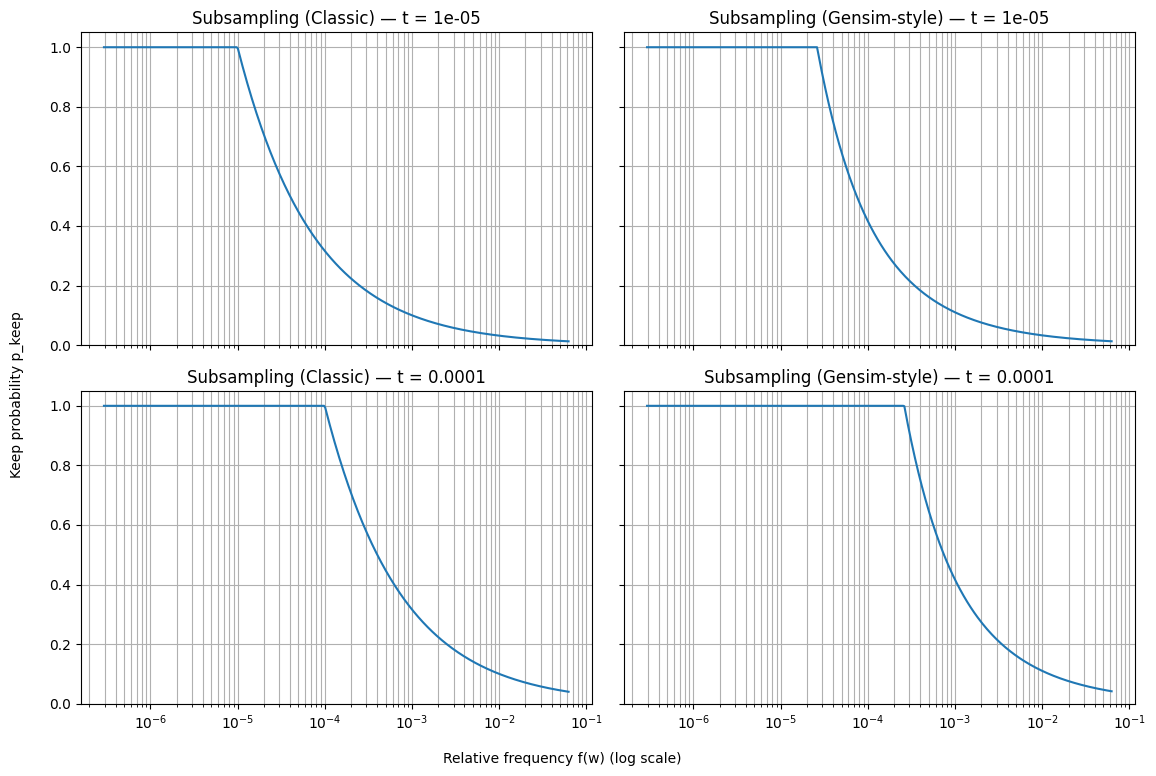

In [27]:
import matplotlib.pyplot as plt

# keep-probability formulas:
# classic
def p_keep_classic(f, t):
    f = np.asarray(f, dtype=float)
    return np.minimum(1.0, np.sqrt(t / f))

# gensim-style
def p_keep_gensim(f, t):
    f = np.asarray(f, dtype=float)
    return np.minimum(1.0, np.sqrt(t / f) + (t / f))

# build frequency grid from corpus
total_tokens = sum(freq.values())
freq_prop = np.array([freq[w] / total_tokens for w in vocab.keys()], dtype=float)

f_min = float(freq_prop.min()) if len(freq_prop) else 1.0 / max(total_tokens, 1)
f_max = float(freq_prop.max()) if len(freq_prop) else f_min * 10

# ensure strictly positive
f_min = max(f_min, 1.0 / total_tokens)
if not np.isfinite(f_min) or not np.isfinite(f_max) or f_min >= f_max:
    f_min, f_max = 1e-8, 1e-1

f_grid = np.logspace(np.log10(f_min), np.log10(f_max), 400)

# plot: 2x2 figure
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

settings = [
    ("Classic", 1e-5, p_keep_classic),
    ("Gensim-style", 1e-5, p_keep_gensim),
    ("Classic", 1e-4, p_keep_classic),
    ("Gensim-style", 1e-4, p_keep_gensim),
]

for ax, (label, t, fn) in zip(axs.ravel(), settings):
    y = fn(f_grid, t)
    ax.semilogx(f_grid, y)
    ax.set_ylim(0, 1.05)
    ax.grid(True, which="both")
    ax.set_title(f"Subsampling ({label}) — t = {t:g}")

fig.text(0.5, 0.04, "Relative frequency f(w) (log scale)", ha="center")
fig.text(0.04, 0.5, "Keep probability p_keep", va="center", rotation="vertical")

plt.tight_layout(rect=[0.06, 0.06, 1, 1])
plt.show()


**Conclusion (Subsampling)**
- Words with **high relative frequency** (e.g., stopwords) have a **low keep probability** and are **heavily thinned**.
- Because thinning is **probabilistic per token** (Bernoulli with $p_{\text{keep}}(w)$), very frequent words are **not removed entirely**; a small, representative sample remains, which helps **preserve co-occurrence structure** while reducing compute.
- **Rare words** ($f(w)\le t$) are **largely unaffected** ($p_{\text{keep}}\approx 1$).
- Increasing $t$ (e.g., $10^{-5}\rightarrow10^{-4}$) **raises** $p_{\text{keep}}$ for a given $f$ and shifts the drop-off to the right, making subsampling **less aggressive** (more tokens kept).
- The **Gensim-style** rule keeps slightly **more** mid-frequency words than the classic rule; at very high $f$, both behave similarly.


In [28]:
# Subsampling config:
SUBSAMPLE_T = 1e-5        
USE_GENSIM_STYLE = True   

In [29]:
# Relative frequencies computed on the ORIGINAL stream (before min_count filtering)
total_tokens = sum(freq.values())
freq_prop = {w: freq[w] / total_tokens for w in vocab} 

In [30]:
# p_keep function
def keep_probability(f, t=SUBSAMPLE_T, gensim_style=USE_GENSIM_STYLE):
    if t is None:
        return 1.0
    base = math.sqrt(t / f)
    return min(1.0, base + (t / f)) if gensim_style else min(1.0, base)


In [31]:
# Apply subsampling over the original tokens
tokens_sub = []
dropped = 0
for w in tokens:
    if w not in stoi:         # we skip the words removed by min_count
        continue
    f = freq_prop[w]
    if random.random() < keep_probability(f):
        tokens_sub.append(w)
    else:
        dropped += 1


In [37]:
# print results
print(f"Before subsampling: {len(tokens):,} tokens")
print(f"After  subsampling: {len(tokens_sub):,} tokens  "
      f"(dropped {dropped:,} -> {dropped/len(tokens):.1%})")

# Re-map to ids for training on the subsampled stream
ids = [stoi[w] for w in tokens_sub]
print(f"IDs length (post-subsample): {len(ids):,}")


Before subsampling: 17,005,207 tokens
After  subsampling: 5,595,988 tokens  (dropped 11,122,856 -> 65.4%)
IDs length (post-subsample): 5,595,988


In [ ]:
import pandas as pd

In [ ]:
counts_sub = Counter(tokens_sub)
N = sum(freq.values())

# keep-prob helpers
def p_keep_classic(f, t): 
    return min(1.0, np.sqrt(t/f))
def p_keep_gensim(f, t):
    return min(1.0, np.sqrt(t/f) + (t/f))

def p_keep(f, t=SUBSAMPLE_T, gensim_style=True):
    return p_keep_gensim(f, t) if gensim_style else p_keep_classic(f, t)

rows = []
K = 20
for w, c in freq.most_common(K):
    f_rel = c / N
    pk = p_keep(f_rel, SUBSAMPLE_T, gensim_style=USE_GENSIM_STYLE)
    kept = counts_sub[w]
    kept_pct = kept / c if c else 0.0
    exp_kept = int(round(c * pk))
    rows.append({
        "word": w,
        "count_before": c,
        "count_after": kept,
        "kept_pct_actual": kept_pct,
        "p_keep_theory": pk,
        "expected_kept": exp_kept,
        "abs_diff_pct": abs(kept_pct - pk)
    })

# convert dec to %
df_keep = pd.DataFrame(rows).assign(
    kept_pct_actual=lambda d: (d["kept_pct_actual"]*100).round(2),
    p_keep_theory=lambda d: (d["p_keep_theory"]*100).round(2),
    abs_diff_pct=lambda d: (d["abs_diff_pct"]*100).round(2)
)

# display
cols = ["word","count_before","count_after","expected_kept","kept_pct_actual","p_keep_theory","abs_diff_pct"]
df_keep[cols]


,word,count_before,count_after,expected_kept,kept_pct_actual,p_keep_theory,abs_diff_pct
0,the,1061396,13654,13605,1.29,1.28,0.00
1,of,593677,10291,10218,1.73,1.72,0.01
2,and,416629,8470,8587,2.03,2.06,0.03
3,one,411764,8496,8538,2.06,2.07,0.01
4,in,372201,8063,8126,2.17,2.18,0.02
5,a,325873,7585,7614,2.33,2.34,0.01
6,to,316376,7483,7505,2.37,2.37,0.01
7,zero,264975,6795,6883,2.56,2.60,0.03
8,nine,250430,6718,6696,2.68,2.67,0.01
9,two,192644,5991,5894,3.11,3.06,0.05


Text(0.5, 1.0, 'Top-10 words: before vs after subsampling (and expected)')

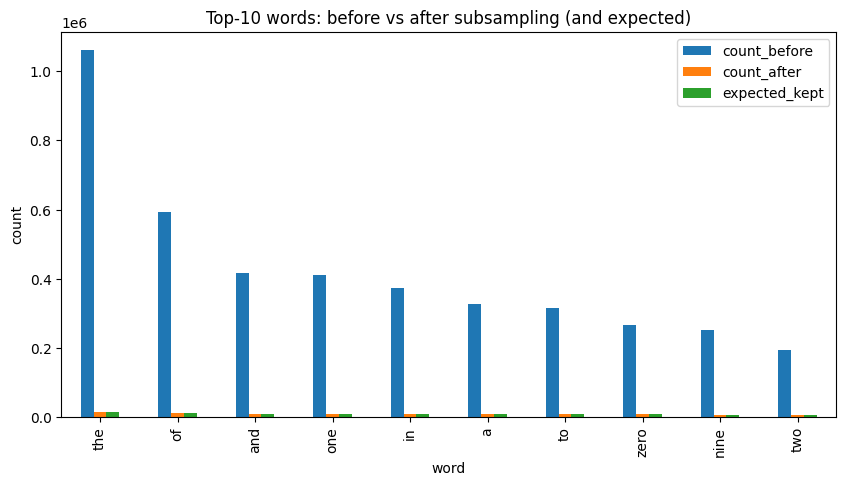

In [36]:
top10 = df_keep.head(10).copy()
ax = top10.plot(x="word", y=["count_before","count_after","expected_kept"], kind="bar", figsize=(10,5))
ax.set_ylabel("count")
ax.set_title("Top-10 words: before vs after subsampling (and expected)")


Subsampling minimizes compute and preserves co-occurrence structure better than hard stopword removal. We gain a truer geometry and avoid the bias created by collapsing sentences when tokens are deleted.


## 4) Build trainig pairs (skip-gram, dynamic window)

We’ll follow the **Skip-gram** architecture from Figure 1 of the paper "Efficient Estimation of Word Representations in
Vector Space" ref: https://arxiv.org/abs/1301.3781 (Mikolov et al., 2013):  
given a **center word** $w_t$, the model predicts its **context words** $w_{t+j}$.


From 

![./sup_imgs/CBOW_Skip-gram.png](./sup_imgs/CBOW_Skip-gram.png)


**Objective**
$$
\max \sum_{t}\sum_{j\in[-r,\,r]\setminus\{0\}} \log p\big(w_{t+j}\mid w_t\big)
$$

**Training recipe (what we implement)**
- **Dynamic window**: $r \sim \mathrm{Uniform}\{1,\dots,W\}$.
- Two embedding matrices: $E_{\text{in}}$ (center) and $E_{\text{out}}$ (context).  
  The word vector we use after training is the row from $E_{\text{in}}$.
- **Negative Sampling**: for each positive pair $(w_t, w_{t+j})$, draw $k$ negatives to
  approximate the softmax efficiently.

**Why Skip-gram first?**
- Simple to implement, **strong for rare words**, and aligns with the classic Word2Vec setup.
(We can add **CBOW** later for a speed/quality comparison.)


### 4.1) Negative Sampling

Training a neural network usually means **slightly adjusting many weights** for each example. In Skip-gram, that’s a problem: with a large vocabulary, the output layer is huge, so a standard softmax would try to update **every** output weight on **every** pair.

**Negative Sampling** changes the game. For each positive pair $(\text{center}, \text{context})$, we:
- keep the **positive** context word, and
- sample a **small set of “negative” words** (words that should score 0 for this center).

We then make **binary predictions** only for these $k{+}1$ words (the one positive and a few negatives). The update touches:
- the **input embedding** of the center word, and
- the **output embeddings** of just the positive and sampled negatives.

All other output weights are ignored for this step. The result is that each example updates **only a tiny subset** of parameters, making training **fast and scalable**, while still teaching the model to pull true contexts closer and push random words away.


### Negative sampling: how we draw negatives

We sample “negative” words from a unigram distribution so that more frequent words are more likely to be chosen; the paper uses a smoothed version.

**Raw unigram (by relative frequency)**  
  $$
  P(w_i)=\frac{f(w_i)}{\sum_{j=1}^{|V|} f(w_j)}
  $$

**Smoothed unigram (preferred, with \(3/4\) power)**  
  $$
  P(w_i)=\frac{f(w_i)^{3/4}}{\sum_{j=1}^{|V|} f(w_j)^{3/4}}
  $$

Where $f(w)$ is the corpus count of word $w$. The $3/4$ exponent flattens the distribution: it slightly downweights very common words and upweights less frequent ones, yielding more informative negatives.


In [40]:
from torch.utils.data import IterableDataset, DataLoader

In [ ]:
# window + negatives
WINDOW_MAX   = 5          # dynamic window upper bound
NEGATIVE_K   = 5          # negatives per positive
BATCH_SIZE   = 4096 if torch.cuda.is_available() else 1024

# negative sampling distribution with the unigram^(3/4)
power = 0.75
counts = np.array([vocab[w] for w in itos], dtype=np.float64)
unigram_pow = counts ** power
neg_prob = unigram_pow / unigram_pow.sum()


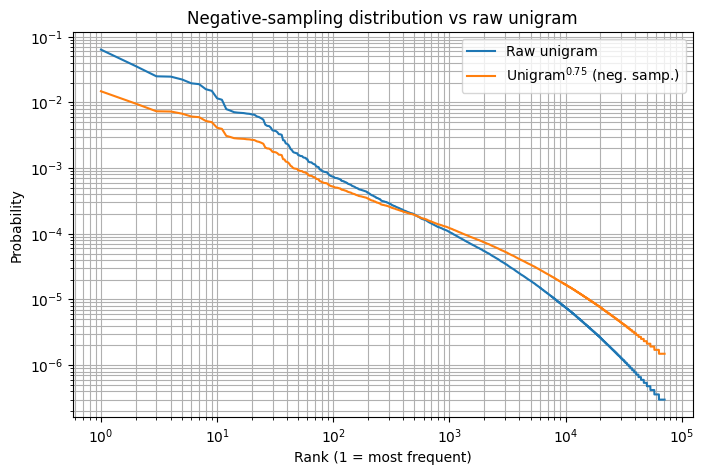

In [45]:
# Plot the negative sampling distribution

# Raw unigram prob and smoothed (unigram^0.75)
raw_prob = counts / counts.sum()
neg_prob = (counts ** 0.75)
neg_prob = neg_prob / neg_prob.sum()

# Rank–probability plot (log–log): raw vs smoothed
order_raw = np.argsort(-raw_prob)
order_neg = np.argsort(-neg_prob)

plt.figure(figsize=(8,5))
plt.loglog(np.arange(1, len(itos)+1), raw_prob[order_raw], label="Raw unigram")
plt.loglog(np.arange(1, len(itos)+1), neg_prob[order_neg], label="Unigram$^{0.75}$ (neg. samp.)")
plt.xlabel("Rank (1 = most frequent)")
plt.ylabel("Probability")
plt.title("Negative-sampling distribution vs raw unigram")
plt.legend()
plt.grid(True, which="both")
plt.show()


**Observation**: The unigram^0.75 curve will sit above raw for mid/low-frequency words and below raw for the very top words, that’s the **“flattening”** effect.

##### But, there's an implementation problem:

For every positive pair we train on, you need *k* negative words drawn from a non-uniform distribution (`neg_prob`, unigram^0.75).
If we have millions of pairs, that’s hundreds of millions of draws!

Doing `np.random.choice(..., p=neg_prob)` every time is relatively slow (it has to process the whole probability vector each draw).

Then, there's a simple trick to avoid this: prebuild a big jar of tickets (`neg_table`) where **each word ID appears as often as its probability**.

Then, when you need negatives, you don’t recompute anything, we just pick random positions in that jar!

In [47]:
# build a big table for fast sampling
NEG_TABLE_SIZE = max(1_000_000, 100 * len(itos))
neg_table = np.random.choice(len(itos), size=NEG_TABLE_SIZE, p=neg_prob)


In [52]:
def sample_negatives(batch_size: int, k: int) -> torch.Tensor:
    idx = np.random.randint(0, NEG_TABLE_SIZE, size=(batch_size, k))
    return torch.tensor(neg_table[idx], dtype=torch.long)


In [53]:
# iterable dataset: stream (center, context) pairs
class SkipGramPairs(IterableDataset):
    def __init__(self, ids, window_max):
        super().__init__()
        self.ids = np.asarray(ids, dtype=np.int32)
        self.window_max = window_max

    def _iter_range(self, start, end, seed=None):
        rng = random.Random(seed)
        for i in range(start, end):
            center = int(self.ids[i])
            r = rng.randint(1, self.window_max)
            left  = max(0, i - r)
            right = min(len(self.ids), i + r + 1)
            for j in range(left, right):
                if j == i: 
                    continue
                yield center, int(self.ids[j])

    def __iter__(self):
        # split work across dataloader workers
        info = torch.utils.data.get_worker_info()
        n = len(self.ids)
        if info is None:
            # single worker
            yield from self._iter_range(0, n, seed=SEED)
        else:
            # shard per worker for deterministic coverage
            w_id, w_num = info.id, info.num_workers
            start = (n * w_id) // w_num
            end   = (n * (w_id + 1)) // w_num
            yield from self._iter_range(start, end, seed=SEED + w_id)


In [54]:
dataset = SkipGramPairs(ids, WINDOW_MAX)


In [55]:
def collate_skipgram(batch):
    # batch = list of (center, context)
    centers, positives = zip(*batch)
    centers  = torch.tensor(centers,  dtype=torch.long)
    positives= torch.tensor(positives,dtype=torch.long)
    negatives= sample_negatives(len(batch), NEGATIVE_K)
    return centers, positives, negatives

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_skipgram,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)


In [56]:
# quick test: pull one batch and print shapes
centers, positives, negatives = next(iter(loader))
print("centers:", centers.shape, "positives:", positives.shape, "negatives:", negatives.shape)
print("example pair:", centers[0].item(), "->", positives[0].item(), "| word:", itos[centers[0].item()], "->", itos[positives[0].item()])

centers: torch.Size([4096]) positives: torch.Size([4096]) negatives: torch.Size([4096, 5])
example pair: 2588 -> 339 | word: anarchism -> abuse


In [60]:
centers[:10]

tensor([ 2588,  2588,  2588,   339,   339, 12010, 12010, 52286, 52286, 52286])

In [61]:
positives[:10]

tensor([  339, 12010, 52286,  2588, 12010,   339, 52286,  2588,   339, 12010])

In [63]:
negatives[:10]

tensor([[45847, 52804, 19557, 29149, 63653],
        [11066, 36789, 23445, 66087, 65452],
        [54032, 26497, 69558, 63912, 44794],
        [45377, 43351, 63879, 29060, 57780],
        [63867,  9651, 43207, 15314,     0],
        [ 8037, 20551, 56134, 20560, 69579],
        [40386,  1163, 34046,  5895, 69316],
        [26242, 36863, 45201, 46557, 33802],
        [30337, 62115, 13772, 47196, 16015],
        [32066, 39180, 45788, 32515,  2637]])

**Observations**

1) centers
    - Shape: [4096]
    - Meaning: for each training example (one row in the batch), this is the center word id.

2) positives
    - Shape: [4096]
    - Meaning: for each example (i.e., for that specific center occurrence), positives[i] is one context word id produced by the dynamic window at that position.

**Notice that same center words are syncronized with different positive words**. That’s why centers repeats and positives varies row-by-row.